# House Price Prediction – Portfolio Project

## 1. Introduction

In this project, the goal is to predict house sale prices using the Kaggle House Prices: Advanced Regression Techniques dataset.
The dataset contains 1,460 residential properties and 80 predictive features describing location, size, quality, and other house characteristics, along with the target variable SalePrice.
This project focuses on building and comparing regression models and identifying the key drivers of house prices.

In [43]:
import os
from pathlib import Path
import pandas as pd

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [44]:
data_path = Path('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df = pd.read_csv(data_path)

df.head()



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [45]:
df.shape

(1460, 81)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [47]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

## 2. Data understanding & cleaning

The original training data has shape (1460, 81): 80 features and 1 target (SalePrice).​
SalePrice is numeric (int64) and ranges from about 34,900 to 755,000, with an average around 180,92 Several features have very high missing rates, especially PoolQC, MiscFeature, Alley, and Fence, each with more than 80–90% missing values, so they were dropped to simplify the model
Other variables (e.g., LotFrontage, garage and basement features, Electrical) have lower missing percentages and are handled later in the modeling pipeline using median imputation for numeric features and most‑frequent imputation for categorical features.

The identifier column Id is removed from the feature matrix, and the modeling dataset becomes:

X: all remaining features (without Id and SalePrice)

y: target variable SalePrice.

In [48]:

missing = (df.isna().sum()).sort_values(ascending=False)
percentage = (df.isna().mean() * 100).sort_values(ascending=False)
missing_data = pd.concat([missing, percentage], axis=1, keys=['Missing Count', 'Missing %'])
print(missing_data[missing_data['Missing Count'] > 0])  

              Missing Count  Missing %
PoolQC                 1453  99.520548
MiscFeature            1406  96.301370
Alley                  1369  93.767123
Fence                  1179  80.753425
MasVnrType              872  59.726027
FireplaceQu             690  47.260274
LotFrontage             259  17.739726
GarageYrBlt              81   5.547945
GarageCond               81   5.547945
GarageType               81   5.547945
GarageFinish             81   5.547945
GarageQual               81   5.547945
BsmtFinType2             38   2.602740
BsmtExposure             38   2.602740
BsmtQual                 37   2.534247
BsmtCond                 37   2.534247
BsmtFinType1             37   2.534247
MasVnrArea                8   0.547945
Electrical                1   0.068493


In [49]:
# Drop very sparse columns first (if not already done)
high_missing_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']
X = X.drop(columns=[c for c in high_missing_cols if c in X.columns])

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

num_cols, len(num_cols), len(cat_cols)



(['MSSubClass',
  'LotFrontage',
  'LotArea',
  'OverallQual',
  'OverallCond',
  'YearBuilt',
  'YearRemodAdd',
  'MasVnrArea',
  'BsmtFinSF1',
  'BsmtFinSF2',
  'BsmtUnfSF',
  'TotalBsmtSF',
  '1stFlrSF',
  '2ndFlrSF',
  'LowQualFinSF',
  'GrLivArea',
  'BsmtFullBath',
  'BsmtHalfBath',
  'FullBath',
  'HalfBath',
  'BedroomAbvGr',
  'KitchenAbvGr',
  'TotRmsAbvGrd',
  'Fireplaces',
  'GarageYrBlt',
  'GarageCars',
  'GarageArea',
  'WoodDeckSF',
  'OpenPorchSF',
  'EnclosedPorch',
  '3SsnPorch',
  'ScreenPorch',
  'PoolArea',
  'MiscVal',
  'MoSold',
  'YrSold'],
 36,
 39)

In [50]:
target = 'SalePrice'

X = df.drop(columns=['Id', target])
y = df[target]

X.shape, y.shape


((1460, 79), (1460,))

## 3. Exploratory data analysis (EDA)

SalePrice is right‑skewed, with most properties priced around the lower to mid ranges and a few very expensive houses in the upper tail.
Log‑transforming SalePrice (for example in additional experiments) can help make the distribution more symmetric, but the main models here use the raw prices for interpretability.

Key numeric features such as living area (GrLivArea), total basement area (TotalBsmtSF), and overall quality scores (OverallQual) show strong positive relationships with SalePrice.
Categorical variables like neighborhood and exterior/overall quality also display clear differences in median prices across categories, indicating that location and quality play important roles in determining value.

### 1. SalePrice distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


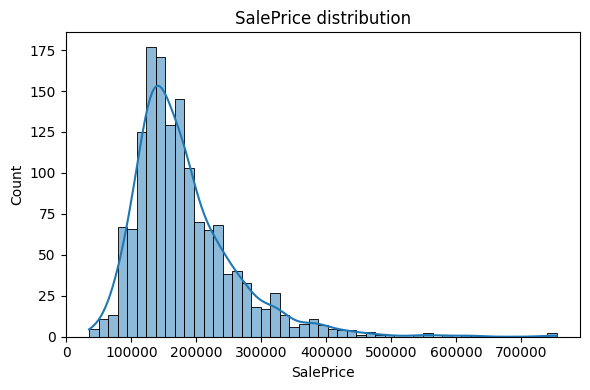

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(df['SalePrice'], kde=True)
plt.title('SalePrice distribution')
plt.xlabel('SalePrice')
plt.ylabel('Count')
plt.tight_layout()


SalePrice is right‑skewed: most houses are in the lower to mid price range, with a smaller number of very expensive properties in the upper tail.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


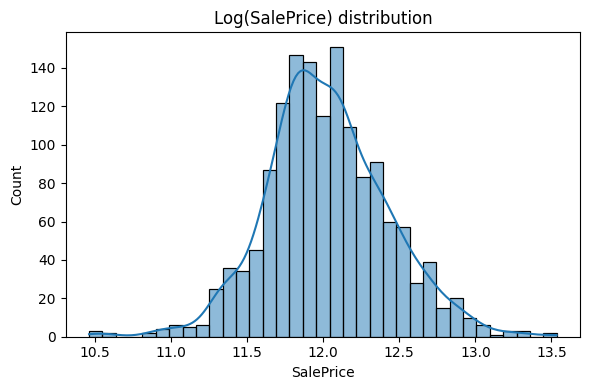

In [58]:
import numpy as np
plt.figure(figsize=(6,4))
sns.histplot(np.log1p(df['SalePrice']), kde=True)
plt.title('Log(SalePrice) distribution')
plt.tight_layout()


Log‑transforming SalePrice makes the distribution more symmetric, which can help some models, but the main results here use the original prices for interpretability

### 2. Relationship with key numeric features

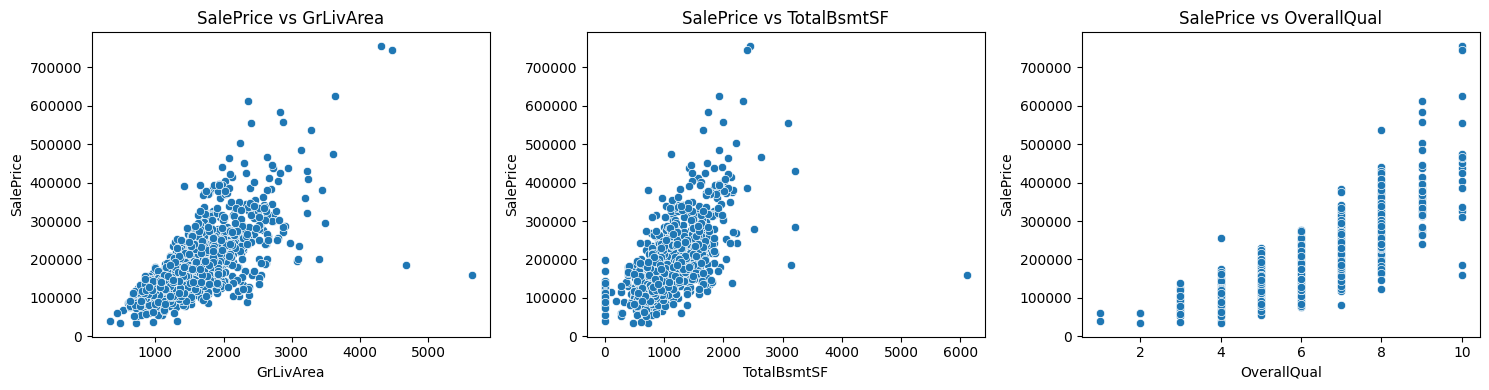

In [59]:
num_focus = ['GrLivArea', 'TotalBsmtSF', 'OverallQual']

plt.figure(figsize=(15,4))
for i, col in enumerate(num_focus, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(data=df, x=col, y='SalePrice')
    plt.title(f'SalePrice vs {col}')
plt.tight_layout()


Larger above‑ground living area (GrLivArea) is strongly associated with higher SalePrice.

Total basement area (TotalBsmtSF) also shows a positive relationship with price.

Higher OverallQual scores correspond to much higher prices, confirming that overall quality is one of the main drivers of value.

### 3. Categorical features vs SalePrice

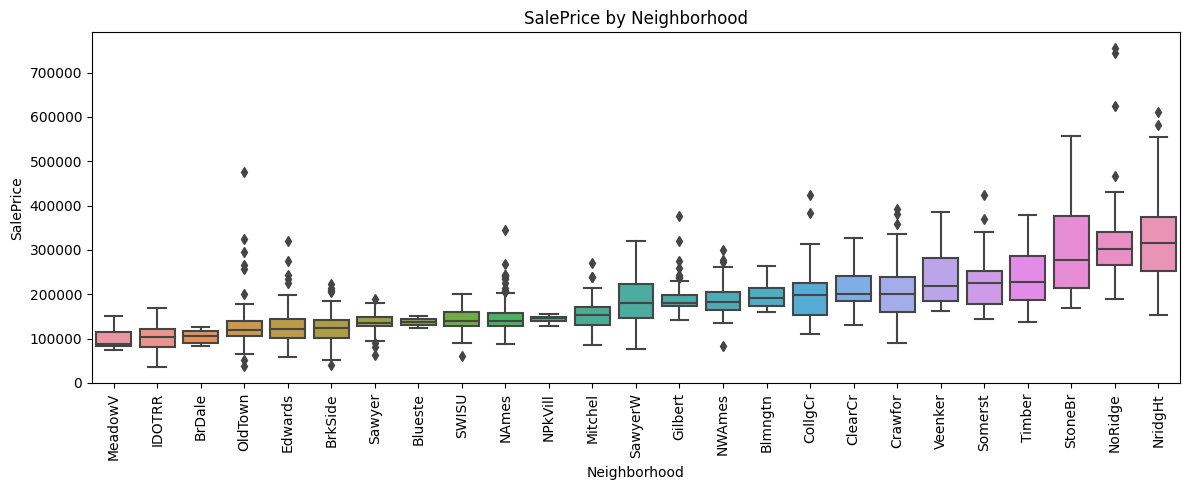

In [60]:
plt.figure(figsize=(12,5))
order = df.groupby('Neighborhood')['SalePrice'].median().sort_values().index
sns.boxplot(data=df, x='Neighborhood', y='SalePrice', order=order)
plt.xticks(rotation=90)
plt.title('SalePrice by Neighborhood')
plt.tight_layout()


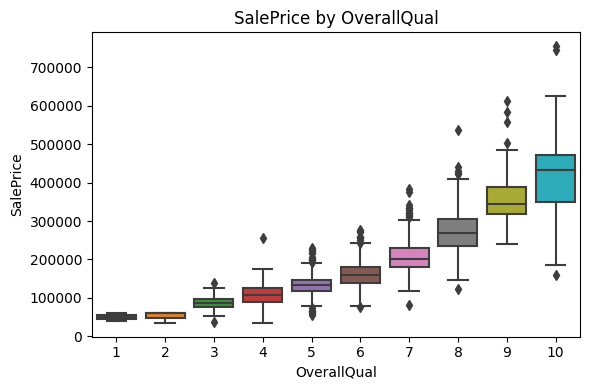

In [61]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='OverallQual', y='SalePrice')
plt.title('SalePrice by OverallQual')
plt.tight_layout()


Median prices vary a lot by Neighborhood, which shows that location has a strong impact on house value.

SalePrice increases clearly with OverallQual; higher quality ratings lead to higher typical prices.

### 4. Correlation heatmap (top features only)

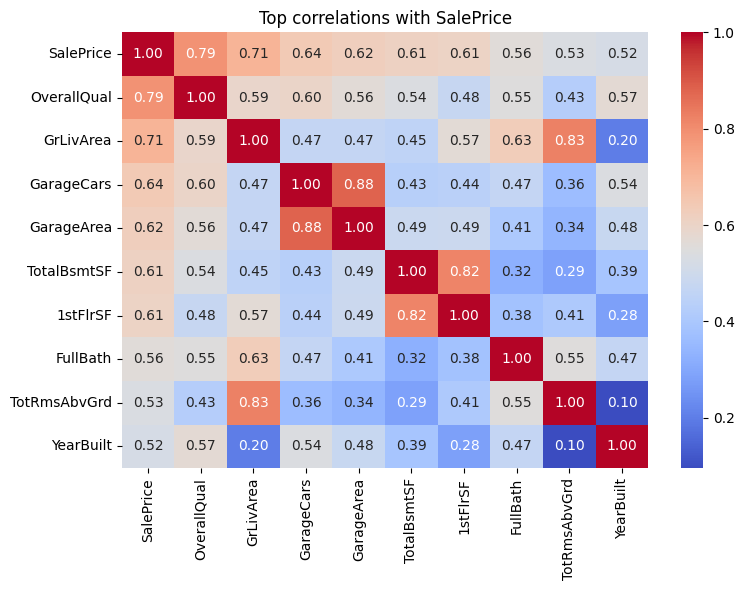

In [62]:
corr = df.corr(numeric_only=True)
top_corr = corr['SalePrice'].sort_values(ascending=False).head(10).index

plt.figure(figsize=(8,6))
sns.heatmap(corr.loc[top_corr, top_corr], annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Top correlations with SalePrice')
plt.tight_layout()


The strongest correlations with SalePrice include OverallQual, GrLivArea, GarageCars, GarageArea, and TotalBsmtSF, supporting the earlier scatterplot findings.

## 4. Modeling

4.1 Train–test split and preprocessing
The data is split into training (80%) and test (20%) sets to evaluate model performance on unseen houses.
A ColumnTransformer is used to build a preprocessing pipeline that imputes missing numeric values with the median, imputes categorical values with the most frequent category, and applies one‑hot encoding to all categorical variables.

4.2 Baseline model – Linear Regression
The first model is a Linear Regression trained on the preprocessed features.
On the test set, it achieves an RMSE of about 31,227 USD and an R² of about 0.87, meaning the model explains roughly 87% of the variance in house prices but still leaves notable error.

4.3 Final model – Gradient Boosting Regressor
To capture non‑linear relationships and feature interactions, a GradientBoostingRegressor with 300 estimators, learning rate 0.05, and max depth 3 is trained on the same preprocessed features.
This model improves performance to an RMSE of about 26,992 USD and an R² of about 0.91, substantially reducing typical prediction error and explaining about 90% of the variance in SalePrice, so it is selected as the final model.

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# Baseline model: Linear Regression
linreg = LinearRegression()

model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', linreg)
])

model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
rmse, r2


(31227.086801675738, 0.8728696897915906)

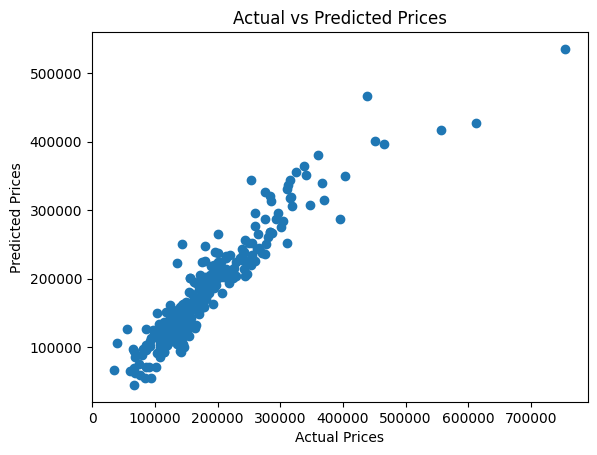

In [52]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

In [53]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr_model = Pipeline(steps=[
    ('preprocess', preprocess),   # same ColumnTransformer you already built
    ('model', gbr)
])

gbr_model.fit(X_train, y_train)

y_pred_gbr = gbr_model.predict(X_test)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_gbr = r2_score(y_test, y_pred_gbr)
rmse_gbr, r2_gbr


(26992.63856227233, 0.9050102281346564)

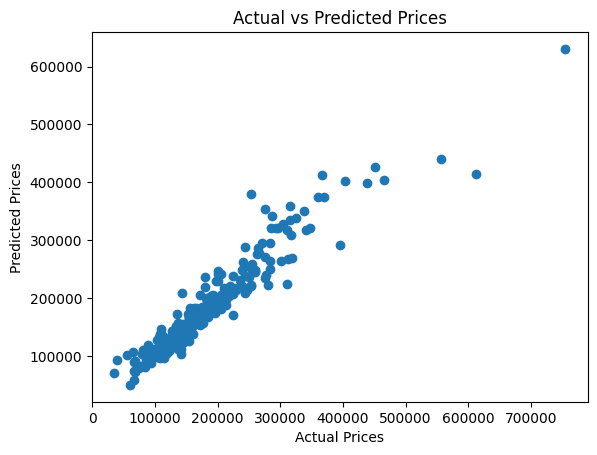

In [54]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_gbr)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

## 5. Feature importance & insights

Feature importances from the Gradient Boosting model highlight which variables most influence predicted prices.
The top features include overall material and finish quality (OverallQual), living area (GrLivArea), total basement area (TotalBsmtSF), garage capacity (GarageCars), and construction/remodel year (e.g., YearBuilt, YearRemodAdd), along with several neighborhood‑related indicators.

Key insights:

Higher overall quality scores and larger living areas are the strongest drivers of higher sale prices.

More garage capacity and larger basement areas are associated with more expensive homes, reflecting the value of parking and usable space.

Newer or recently remodeled houses generally command higher prices than older properties, holding other features constant.

Neighborhood features show that location has a major impact on value, with some neighborhoods consistently pricing higher than others.

In [55]:
import numpy as np
import pandas as pd

# access fitted preprocessing + model
ct = gbr_model.named_steps['preprocess']
gbr = gbr_model.named_steps['model']

# get feature names after preprocessing
ohe = ct.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([num_cols, cat_feature_names])

# feature importances
fi = pd.DataFrame({
    'feature': all_feature_names,
    'importance': gbr.feature_importances_
}).sort_values(by='importance', ascending=False)

fi.head(15)


,feature,importance
3,OverallQual,0.504528
15,GrLivArea,0.145946
25,GarageCars,0.046198
11,TotalBsmtSF,0.042541
8,BsmtFinSF1,0.034833
13,2ndFlrSF,0.029150
12,1stFlrSF,0.028851
243,GarageFinish_Unf,0.016425
2,LotArea,0.016358
178,BsmtQual_Ex,0.013339


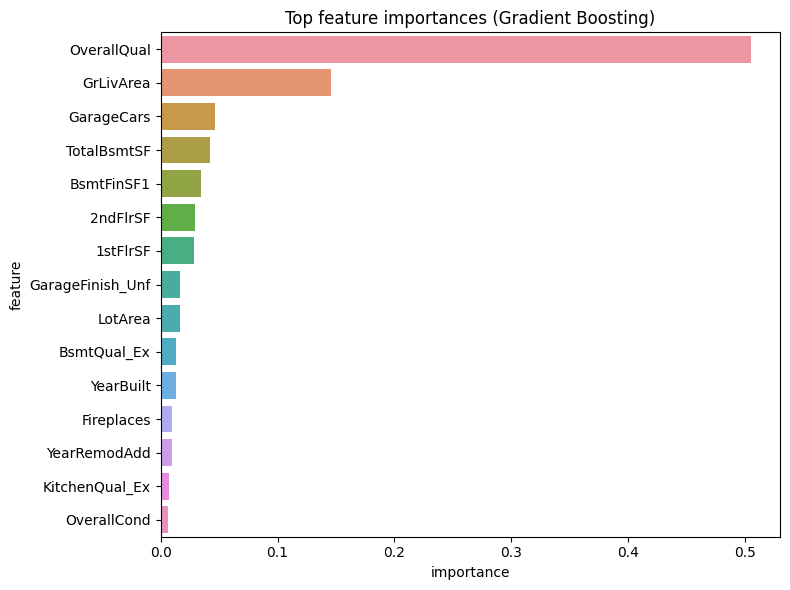

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

top_n = 15
plt.figure(figsize=(8, 6))
sns.barplot(data=fi.head(top_n), x='importance', y='feature')
plt.title('Top feature importances (Gradient Boosting)')
plt.tight_layout()


## 6. Limitations & next steps

This project uses only the Kaggle house‑price dataset, so results may not generalize to other cities or markets without retraining.
The current models use a single train–test split and limited hyperparameter tuning; further improvement could come from cross‑validation and more systematic tuning of tree‑based methods such as Gradient Boosting, XGBoost, or LightGBM.

Future work could include experimenting with log‑transformed prices, engineering additional domain‑specific features (such as price per square meter or age buckets), and deploying the final model in a simple web app to estimate house prices given user inputs.